# Homework 4 - Part 1

1. Build a toy OAS model based on pass-thorugh structure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Important terms and conditions:

Assume all loans are 4.075%, 358 mth maturity.

33 WALA, 33 months since origination and when the Passthrough was issued.

Net Coupon 3.5% and servicing /guarantee fee 0.575%.

Assume SMMs idential during first 33 months and solve for SMM such that factor is 0.64702083.

Original Loan Balance 1,030,969,748,038.00.

Current Loan Balance 667, 058,907,009.

Regarding given CPRs, assume al are curtailments ( no prepaymens).

In [2]:
current_loan_balance = 667_058_907_009
original_loan_balance = 1_030_969_748_038
factor = current_loan_balance / original_loan_balance # 0.64702083
fee = 0.00575
c = 0.04075
og_maturity = 358
WALA = 33

Let us load the CPR and forward rate data.

In [3]:
cpr_data = pd.read_csv('data/hw4_CPR.csv')
cpr_data.index = pd.to_datetime(cpr_data['Pay Date'], format='%m/%y')
cpr_data.drop(columns=['Pay Date'], inplace=True)
cpr_data.index = cpr_data.index.to_period('M')

# strip left and right spaces from the column names
cpr_data.columns =  [col.strip() for col in cpr_data.columns]
cpr_data = cpr_data / 100

In [4]:
cpr_data.head()

,-140 BPs,-120 BPs,-100 BPs,-80 BPs,-60 BPs,-40 BPs,-20 BPs,0 BPs,20 BPs,40 BPs,60 BPs,80 BPs,100 BPs,120 BPs,140 BPs
Pay Date,,,,,,,,,,,,,,,
2018-03,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780,0.0780
2018-04,0.0798,0.0798,0.0797,0.0798,0.0798,0.0798,0.0798,0.0797,0.0798,0.0798,0.0798,0.0798,0.0797,0.0799,0.0799
2018-05,0.1288,0.1180,0.1083,0.1001,0.0917,0.0839,0.0762,0.0693,0.0614,0.0497,0.0462,0.0439,0.0416,0.0395,0.0374
2018-06,0.2997,0.2447,0.1961,0.1589,0.1333,0.1146,0.0966,0.0805,0.0593,0.0530,0.0476,0.0425,0.0409,0.0395,0.0382
2018-07,0.3075,0.2406,0.1907,0.1564,0.1325,0.1145,0.0970,0.0813,0.0609,0.0545,0.0490,0.0437,0.0421,0.0407,0.0393


In [5]:
rate_data = pd.read_csv('data/hw4_LIBOR.csv')

rate_data.dropna(inplace=True)
# convert the date into month and year due to our application scope
rate_data.index = pd.to_datetime(rate_data['Date'])
rate_data.index = rate_data.index.to_period('M')
rate_data.drop(columns=['Date'], inplace=True)
rate_data = rate_data / 100

In [6]:
rate_data.head()

,Spot
Date,
2018-03,0.018500
2018-04,0.018668
2018-05,0.018755
2018-06,0.020216
2018-07,0.020545


In [7]:
len(rate_data.index), len(cpr_data.index)

(362, 362)

In [8]:
all(rate_data.index == cpr_data.index)

True

In [9]:
type(rate_data.index[0])

pandas._libs.tslibs.period.Period

Given forward LIBOR data and CPR data is clean such that they have the same index and length, no need to clean the data or merge them.

In [10]:
from homework_utils.previous_homework_func import calcualte_monthly_payment

class CPRConvertor:
    @staticmethod
    def to_smm(cpr: float):
        return 1 - (1 - cpr) ** (1/12)
    
class MBS:
    def __init__(self, principal: float, wac: float,  og_maturity: int, og_principal: float, servicing_fee: float,  current_month: int, current_month_period: pd.Period):
        """
        MBS class that simulates the MBS cashflows given the parameters. Assumes all loans have the same Coupon rate as WAC and same maturity.
        Curtailments are assumed to be the only prepayments. (No prepayments)
        :param principal: current principal/loan balance
        :param wac:  Weighted Average Coupon rate
        :param og_maturity:  original maturity of the loan
        :param og_principal:  original principal of the loan
        :param servicing_fee:  servicing fee + guarantee fee
        :param current_month:  current time to maturity
        """
        self.principal = principal # current principal amount
        self.wac = wac
        self.og_maturity = og_maturity
        self.og_principal = og_principal
        self.servicing_fee = servicing_fee
        self.t = current_month # current month index
        self.t_period_index = current_month_period
        self.monthly_payment = calcualte_monthly_payment(self.og_principal, self.wac, self.og_maturity)
        self._ongoing = principal > 0        
        self._cashflows = {}
    
    def next_month_cash_flow(self, smm: float):
        """
        Calculate the cash flow for the next month given the SMM from time t to t+1.
        Cash flow includes total payment, interest, principal, servicing fee, scheduled principal, curtailment, net_cash_flow, net_interest_payment, etc
        :param smm: float 
        :return: dictionary of cash flows of each type
        """
        
        if not self._ongoing:
            raise ValueError('Loan has been paid off')
        
        
        prev_principal = self.principal
        interest_payment = self.principal * self.wac / 12
        scheduled_principal = self.monthly_payment - interest_payment
        
        if self.principal <= scheduled_principal:
            # last month of the loan (everyone pays off the loan)
            smm = 0 # no prepayments 
            self._ongoing = False
            scheduled_principal = self.principal        

        curtailment = (self.principal - scheduled_principal) * smm # scheduled balance * SMM
        total_payment =self.monthly_payment + curtailment
        principal_payment = scheduled_principal + curtailment
        net_interest_payment = interest_payment * (1 - self.servicing_fee/12)
        net_cash_flow = principal_payment + net_interest_payment
        self.principal -= principal_payment
        self.t += 1
        self.t_period_index += 1
        cashflow_record = {
            'month_index': self.t,
            'month_period': self.t_period_index,
            'total_payment': total_payment,
            'interest_payment': interest_payment,
            'principal_payment': principal_payment,
            'scheduled_principal': scheduled_principal,
            'net_interest_payment': net_interest_payment,
            'curtailment': curtailment,
            'net_cash_flow': net_cash_flow,
            'principal': self.principal,
            'prev_principal': prev_principal
        }
    
        self._cashflows[self.t_period_index] = cashflow_record
        return cashflow_record
    
    def get_cashflows(self):
        return self._cashflows
    
    def has_next_month(self):
        return self._ongoing
    
    

## Demonstration & Insanity Check
Let us write a quick testing function to test the MBS class.

In [11]:
current_month_period = rate_data.index[0]-1
mbs = MBS(principal = current_loan_balance, wac = c,  og_maturity = og_maturity , og_principal= original_loan_balance, 
          servicing_fee = fee,  current_month = WALA, current_month_period= current_month_period)
test_CRP = 0.078
test_SMM = CPRConvertor.to_smm(test_CRP)
print("Test CPR: ", test_CRP)
print("Test SMM: ", round(test_SMM, 6))

print("Has next month cash flow: ", mbs.has_next_month())

_data = mbs.next_month_cash_flow(smm=test_SMM)
_data

Test CPR:  0.078
Test SMM:  0.006745
Has next month cash flow:  True


{'month_index': 34,
 'month_period': Period('2018-03', 'M'),
 'total_payment': 9461642336.12666,
 'interest_payment': 2265220871.718063,
 'principal_payment': 7196421464.408596,
 'scheduled_principal': 2715654340.866073,
 'net_interest_payment': 2264135453.383698,
 'curtailment': 4480767123.542522,
 'net_cash_flow': 9460556917.792294,
 'principal': 659862485544.5914,
 'prev_principal': 667058907009}

In [12]:
print("monthly_payment" , _mp:= calcualte_monthly_payment(original_loan_balance, c, og_maturity), ", test result; ", round(_data['scheduled_principal'] + _data['interest_payment'], 2) == round(_mp, 2))
print("interest_payment" , _ip:= current_loan_balance * c / 12, ", test result; ", round(_data['interest_payment'], 2) == round(_ip, 2))
print('scheduled_principal_payment', _sp:= _mp - _ip, ", test result; ", round(_data['scheduled_principal'], 2) == round(_sp, 2))
print("curtailment" , _curt:= (current_loan_balance - _sp) * test_SMM, ", test result; ", round(_data['curtailment'], 2) == round(_curt, 2))
print("principal_payment" , _pp:= _sp + _curt, ", test result; ", round(_data['principal_payment'], 2) == round(_pp, 2))

monthly_payment 4980875212.584136 , test result;  True
interest_payment 2265220871.718063 , test result;  True
scheduled_principal_payment 2715654340.866073 , test result;  True
curtailment 4480767123.542522 , test result;  True
principal_payment 7196421464.408596 , test result;  True


In [13]:
_data = mbs.next_month_cash_flow(smm=test_SMM)
_data

{'month_index': 35,
 'month_period': Period('2018-04', 'M'),
 'total_payment': 9412940119.493423,
 'interest_payment': 2240783023.8285084,
 'principal_payment': 7172157095.664915,
 'scheduled_principal': 2740092188.7556276,
 'net_interest_payment': 2239709315.296257,
 'curtailment': 4432064906.909287,
 'net_cash_flow': 9411866410.961172,
 'principal': 652690328448.9265,
 'prev_principal': 659862485544.5914}

In [14]:
_balance_at_second_month = _data['prev_principal']
print("interest payment:", _ip2:= _balance_at_second_month * c / 12, ", test result; ", round(_data['interest_payment'], 2) == round(_ip2, 2))
print("scheduled payment:", _sp2 := calcualte_monthly_payment(original_loan_balance, c, og_maturity) - _ip2, ", test result; ", round(_data['scheduled_principal'], 2) == round(_sp2, 2))
print("curtailment", _curt2:= (_balance_at_second_month - _sp2) * test_SMM, ", test result; ", round(_data['curtailment'], 2) == round(_curt2, 2))

interest payment: 2240783023.8285084 , test result;  True
scheduled payment: 2740092188.7556276 , test result;  True
curtailment 4432064906.909287 , test result;  True


This gives me a little confidence that the MBS class is working as expected.

Now let us construct yield curve class for convenience. 

In [15]:
class YieldCurve:    
    def __init__(self, rate_data: pd.DataFrame):
        self._data = rate_data
    
    def get_forward_rate(self, month_period: pd.Period):
        if month_period not in self._data.index:
            raise ValueError('No forward rate for the given period')
        return self._data.loc[month_period].values[0]
    
    def shock(self, shock: float):
        self._data = self._data + shock

Quick test as follow:

In [16]:
# Quick test 
test_SMM = 0.078
mbs = MBS(principal = current_loan_balance, wac = c,  og_maturity = og_maturity , og_principal= original_loan_balance, 
          servicing_fee = fee,  current_month = WALA, current_month_period= current_month_period)
k = 0
base_case_yield = YieldCurve(rate_data)
while mbs.has_next_month() and k <5:
    _data = mbs.next_month_cash_flow(smm=test_SMM)
    print(_data['month_period'])
    print(f"Forward Rate", round(base_case_yield.get_forward_rate(_data['month_period']),6))
    k += 1
rate_data.head()

2018-03
Forward Rate 0.0185
2018-04
Forward Rate 0.018668
2018-05
Forward Rate 0.018755
2018-06
Forward Rate 0.020216
2018-07
Forward Rate 0.020545


,Spot
Date,
2018-03,0.018500
2018-04,0.018668
2018-05,0.018755
2018-06,0.020216
2018-07,0.020545


In [17]:
cashflows = {}
for bps in cpr_data.columns:
    cpr_series = cpr_data[bps]
    mbs = MBS(principal = current_loan_balance, wac = c,  og_maturity = og_maturity , og_principal= original_loan_balance, 
          servicing_fee = fee,  current_month = WALA, current_month_period= current_month_period)
    bps_cashflows = {}
    
    while mbs.has_next_month():
        next_month_period = mbs.t_period_index + 1
        smm = CPRConvertor.to_smm(cpr_series.loc[next_month_period])
        _data = mbs.next_month_cash_flow(smm=smm)
        bps_cashflows[_data['month_period']] = _data
    cashflows[bps] = bps_cashflows

# print length for each BPS
for bps, bps_cashflows in cashflows.items():
    print(f"For CPR situation {bps}: ", "the MBS has cashflow records", len(bps_cashflows))

For CPR situation -140 BPs:  the MBS has cashflow records 71
For CPR situation -120 BPs:  the MBS has cashflow records 78
For CPR situation -100 BPs:  the MBS has cashflow records 83
For CPR situation -80  BPs:  the MBS has cashflow records 88
For CPR situation -60  BPs:  the MBS has cashflow records 93
For CPR situation -40 BPs:  the MBS has cashflow records 98
For CPR situation -20 BPs:  the MBS has cashflow records 103
For CPR situation 0 BPs:  the MBS has cashflow records 108
For CPR situation 20 BPs:  the MBS has cashflow records 115
For CPR situation 40 BPs:  the MBS has cashflow records 117
For CPR situation 60 BPs:  the MBS has cashflow records 120
For CPR situation 80 BPs:  the MBS has cashflow records 122
For CPR situation 100 BPs:  the MBS has cashflow records 123
For CPR situation 120 BPs:  the MBS has cashflow records 124
For CPR situation 140 BPs:  the MBS has cashflow records 125


### Insanity Check for the Cashflows

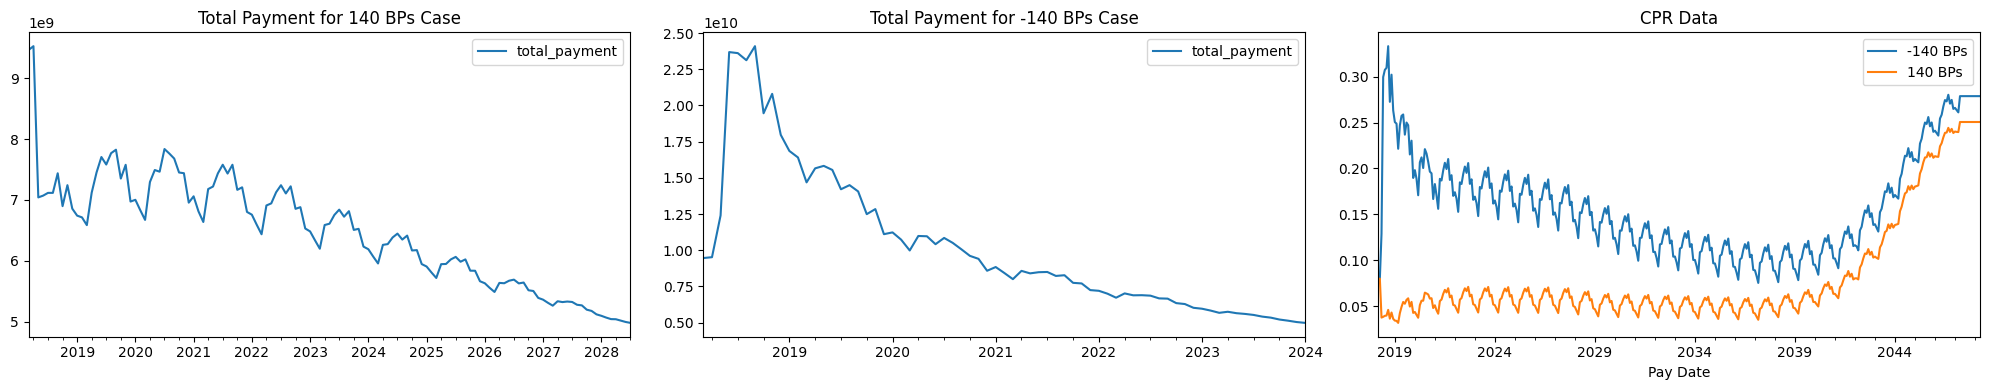

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))  # Adjust figsize to fit your needs

pd.DataFrame.from_dict(cashflows['140 BPs'], orient = 'index')[['total_payment']].plot(ax = axes[0], title='Total Payment for 140 BPs Case')
pd.DataFrame.from_dict(cashflows['-140 BPs'], orient = 'index')[['total_payment']].plot(ax = axes[1], title = 'Total Payment for -140 BPs Case')
cpr_data[['-140 BPs', '140 BPs']].plot(ax = axes[2], title='CPR Data')

plt.tight_layout()
plt.show()

### Calculate the WAL each month through time for each path

In [19]:
from homework_utils.previous_homework_func import calculate_WAL

_bps_list = ['-40 BPs', '-20 BPs', '0 BPs', '20 BPs', '40 BPs']
_bps_dict ={
    _bps : pd.DataFrame.from_dict(cashflows[_bps], orient = 'index') for _bps in _bps_list
}
_highest_df = sorted([(_bps_dict[bps], len(cashflows[bps])) for bps in _bps_list], key = lambda x: x[1], reverse = True)[0][0]
display_plot_df = pd.DataFrame().reindex(_highest_df.index)

for _bps in _bps_list:
    _bps_cashflows_df = _bps_dict[_bps]
    WALs = []
    col_name = f'WAL@{_bps}'
    for k in range(0, len(_bps_cashflows_df)):
        all_principal_payments_list = [_bps_cashflows_df['principal_payment'].tolist()]
        all_balances_list = [_bps_cashflows_df['principal'].tolist()]
        WALs.append(calculate_WAL(all_principal_payments_list, all_balances_list, k, unit = 'year'))
    _bps_cashflows_df[col_name] = WALs
    display_plot_df[col_name] = _bps_cashflows_df[col_name]
display_plot_df.fillna(0, inplace=True)

In [20]:
display_plot_df

,WAL@-40 BPs,WAL@-20 BPs,WAL@0 BPs,WAL@20 BPs,WAL@40 BPs
2018-03,3.6707,3.9289,4.2018,4.5574,4.6963
2018-04,3.6274,3.8884,4.1644,4.5240,4.6644
2018-05,3.5852,3.8466,4.1230,4.4832,4.6202
2018-06,3.5529,3.8117,4.0857,4.4414,4.5772
2018-07,3.5206,3.7769,4.0485,4.4003,4.5347
...,...,...,...,...,...
2027-07,0.0000,0.0000,0.0000,0.0948,0.1970
2027-08,0.0000,0.0000,0.0000,0.0833,0.1564
2027-09,0.0000,0.0000,0.0000,0.0000,0.1169
2027-10,0.0000,0.0000,0.0000,0.0000,0.0833


<Axes: title={'center': 'WAL for different BPS(-40 BPs ,-20 BPs ,0 BPs ,20 BPs ,40 BPs)'}>

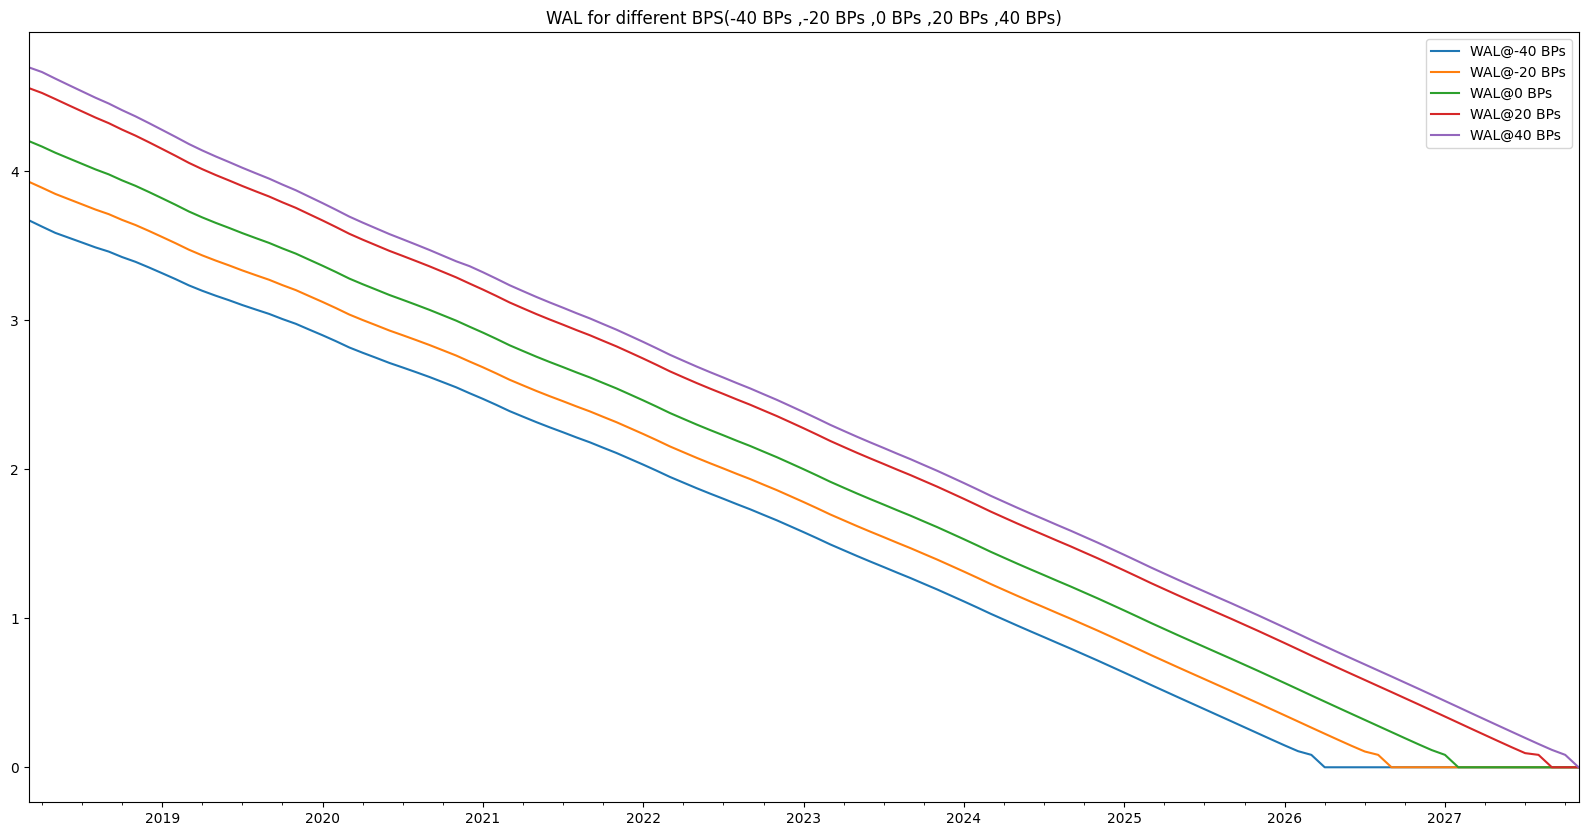

In [21]:
display_plot_df.plot(figsize=(20, 10), title=f"WAL for different BPS({ ' ,'.join(_bps_list) })")

### Solve for OAS

Adding the net cash flow into a dictionary for discounting purposes.

In [22]:
_bps_list

['-40 BPs', '-20 BPs', '0 BPs', '20 BPs', '40 BPs']

In [23]:
_bps_dict['0 BPs'][['net_cash_flow']].head()

,net_cash_flow
2018-03,9.460557e+09
2018-04,9.512238e+09
2018-05,8.857310e+09
2018-06,9.462246e+09
2018-07,9.457220e+09


In [24]:
cash_flow_dict = {bps: _bps_dict[bps][['net_cash_flow']].to_dict()['net_cash_flow'] for bps in _bps_list}

In [25]:
# import color print library

def calculate_MBS_price(cash_flows: dict, yield_curve: YieldCurve, oas: float, verbose = False):
    """
    Calculate the MBS price given the cash flows, yield curve, and OAS
    :param cash_flow_dict: dictionary of cash flows for each BPS
    :param yield_curve: YieldCurve object
    :param oas: OAS
    :return: MBS price
    """
    price = 0
    wala = min(cash_flows.keys())-1
    
    max_period = max(cash_flows.keys())
    total_periods_length = (max_period - wala).n
    discount_factor_map = {}
    discount_factor_map[wala] = 1
    for i in range(1, total_periods_length+1):
        period = wala + i
        forward_rate = yield_curve.get_forward_rate(period)
        discount_factor = discount_factor_map[period-1] * (1 / (1 + (oas + forward_rate) / 12 ))
        discount_factor_map[period] = discount_factor
     
    for period, cash_flow in cash_flows.items():
        forward_rate = yield_curve.get_forward_rate(period)
        discounted_cf = cash_flow * discount_factor_map[period]
        price += discounted_cf
        if verbose:
            print(f"Period: {period}, Forward Rate: {forward_rate}, Cash Flow: {cash_flow}, Discounted Cash Flow: {discounted_cf}, period : {period} - wala: {wala}")
    return price

Let us test if shock works as expected for the yield curve class.

In [26]:
yield_curve = YieldCurve(rate_data)
yield_curve._data.head()

,Spot
Date,
2018-03,0.018500
2018-04,0.018668
2018-05,0.018755
2018-06,0.020216
2018-07,0.020545


In [27]:
bps = '-40 BPs'
rate_shock_val= float(bps.split(' ')[0])/10000
yield_curve.shock(rate_shock_val)
yield_curve._data.head()

,Spot
Date,
2018-03,0.014500
2018-04,0.014668
2018-05,0.014755
2018-06,0.016216
2018-07,0.016545


It works.

In [28]:
def avg_mbs_price(oas: float, cash_flows_bps_dict: dict):
    """
    Calculate the average MBS price given the OAS, cash flows, and yield curve
    :param oas: OAS
    :param cash_flows_bps_dict: dictionary of cash flows for each BPS
    :param yield_curve: YieldCurve object
    :return: average MBS price
    """
    prices = []
    for bps, cash_flows in cash_flows_bps_dict.items():
        yield_curve = YieldCurve(rate_data)
        rate_shock_val= float(bps.split(' ')[0])/10000
        yield_curve.shock(rate_shock_val)
        price = calculate_MBS_price(cash_flows, yield_curve, oas)
        prices.append(price)
    return np.mean(prices)

In [29]:
print(" Reminder of what the cash_flow_dict looks like: ", cash_flow_dict.keys())
print(" Reminder of what the element of cash_flow_dict looks like: ", list(list(cash_flow_dict.values())[0])[0:5], "....")

avg_mbs_price(0.01, cash_flow_dict)

 Reminder of what the cash_flow_dict looks like:  dict_keys(['-40 BPs', '-20 BPs', '0 BPs', '20 BPs', '40 BPs'])
 Reminder of what the element of cash_flow_dict looks like:  [Period('2018-03', 'M'), Period('2018-04', 'M'), Period('2018-05', 'M'), Period('2018-06', 'M'), Period('2018-07', 'M')] ....


681553648292.9528

In [30]:
np.log10(avg_mbs_price(0.01, cash_flow_dict))

11.833500046877333

In [31]:
np.log10(current_loan_balance)

11.824164187528726

In [32]:
from scipy.optimize import fsolve

market_price = current_loan_balance * (100 + 7/32) / 100
def f(oas):
    return abs(avg_mbs_price(oas, cash_flow_dict) - market_price)

result = fsolve(f, 0.01, xtol=1e-6)
oas = result[0]
print(f"OAS: {round(oas, 6)}")
print(f"Market Price-mbs_price: {round(market_price - avg_mbs_price(oas, cash_flow_dict), 2)}")

OAS: 0.015101
Market Price-mbs_price: -0.0


## OAS calculation result  (Problem 1 - OAS)

The OAS is 0.014885.

# Interest Rate Sensitivities (Problem 2 - Interest Rate Sensitivities)

In [33]:
class MBS_PV_Calculator:
    
    @staticmethod
    def calculate_MBS_PV_cashflow(cash_flows: dict, yield_curve: YieldCurve, oas: float,):
        """
        Calculate the MBS price given the cash flows, yield curve, and OAS
        :param cash_flow_dict: dictionary of cash flows for each BPS
        :param yield_curve: YieldCurve object
        :param oas: OAS
        :return: MBS price
        """
        price = 0
        wala = min(cash_flows.keys())-1
        
        max_period = max(cash_flows.keys())
        total_periods_length = (max_period - wala).n
        discount_factor_map = {}
        discount_factor_map[wala] = 1
        for i in range(1, total_periods_length+1):
            period = wala + i
            forward_rate = yield_curve.get_forward_rate(period)
            discount_factor = discount_factor_map[period-1] * (1 / (1 + (oas + forward_rate) / 12 ))
            discount_factor_map[period] = discount_factor
         
        for period, cash_flow in cash_flows.items():
            discounted_cf = cash_flow * discount_factor_map[period]
            price += discounted_cf
        return price
    
    @staticmethod
    def calcualte_MBS_PV_multiple_cashflows_rates(oas: float, cash_flows_bps_dict: dict):
        """
        Calculate the average MBS price given the OAS, cash flows, and yield curve
        :param oas: OAS
        :param cash_flows_bps_dict: dictionary of cash flows for each BPS
        :param yield_curve: YieldCurve object
        :return: average MBS price
        """
        prices = []
        for bps, cash_flows in cash_flows_bps_dict.items():
            yield_curve = YieldCurve(rate_data)
            rate_shock_val= float(bps)/10000
            yield_curve.shock(rate_shock_val)
            price = calculate_MBS_price(cash_flows, yield_curve, oas)
            prices.append(price)
        return np.mean(prices)

### PV01 

Assuming cash flows are the same i.e. assuming CPRs do not change when rates are shocked.

In [34]:
# PV01 
base_case_yield = YieldCurve(rate_data)
base_case_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas)

shock = 0.0001 # 1 basis point
yield_curve = YieldCurve(rate_data)
yield_curve.shock(shock)
shocked_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = yield_curve, oas = oas)

PV01 = shocked_MBS_price - base_case_MBS_price

print("Base Case MBS Price: ", round(base_case_MBS_price, 2))
print("Shocked MBS Price: ", round(shocked_MBS_price, 2))
print(f"PV01: {round(PV01, 2)}", f", PV01 in percentage: {round(PV01 / base_case_MBS_price * 100, 2)}%")

Base Case MBS Price:  669046363349.27
Shocked MBS Price:  668794234838.59
PV01: -252128510.68 , PV01 in percentage: -0.04%


### PV-100

In [35]:
# PV-100
base_case_yield = YieldCurve(rate_data)
base_case_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas)

shock = -0.01 # -100 basis point
yield_curve = YieldCurve(rate_data)
yield_curve.shock(shock)
shocked_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = yield_curve, oas = oas)

PV_minus_100 = shocked_MBS_price - base_case_MBS_price

print("Base Case MBS Price: ", round(base_case_MBS_price, 2))
print("Shocked MBS Price: ", round(shocked_MBS_price, 2))
print(f"PV-100: {round(PV_minus_100, 2)}", f", PV-100 in percentage: {round(PV_minus_100 / base_case_MBS_price * 100, 2)}%")

Base Case MBS Price:  669046363349.27
Shocked MBS Price:  694974373124.79
PV-100: 25928009775.52 , PV-100 in percentage: 3.88%


### PV100

In [36]:
# PV100
base_case_yield = YieldCurve(rate_data)
base_case_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas)

shock = 0.01 # 100 basis point
yield_curve = YieldCurve(rate_data)
yield_curve.shock(shock)
shocked_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = yield_curve, oas = oas)

PV_100 = shocked_MBS_price - base_case_MBS_price

print("Base Case MBS Price: ", round(base_case_MBS_price, 2))
print("Shocked MBS Price: ", round(shocked_MBS_price, 2))
print(f"PV100: {round(PV_100, 2)}", f", PV100 in percentage: {round(PV_100 / base_case_MBS_price * 100, 2)}%")

Base Case MBS Price:  669046363349.27
Shocked MBS Price:  644504886165.59
PV100: -24541477183.68 , PV100 in percentage: -3.67%


# Credit Spread Sensitivites (Problem 3 - Credit Spread Sensitivities)

### CS PV01

In [37]:
base_case_yield = YieldCurve(rate_data)
base_case_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas)

shock = 0.0001 # 1 basis point
oas_shocked = oas + shock
shocked_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas_shocked)

CS_PV01 = shocked_MBS_price - base_case_MBS_price

print("Base Case MBS Price: ", round(base_case_MBS_price, 2))
print("Shocked MBS Price: ", round(shocked_MBS_price, 2))
print(f"CS PV01: {round(CS_PV01, 2)}", f", CS PV01 in percentage: {round(CS_PV01 / base_case_MBS_price * 100, 2)}%")

Base Case MBS Price:  669046363349.27
Shocked MBS Price:  668794234838.59
CS PV01: -252128510.68 , CS PV01 in percentage: -0.04%


### CS PV-100

In [38]:
# CS PV-100
base_case_yield = YieldCurve(rate_data)
base_case_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas)

shock = -0.01 # -100 basis point
oas_shocked = oas + shock
shocked_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas_shocked)

CS_PV_minus_100 = shocked_MBS_price - base_case_MBS_price

print("Base Case MBS Price: ", round(base_case_MBS_price, 2))
print("Shocked MBS Price: ", round(shocked_MBS_price, 2))
print(f"CS PV-100: {round(CS_PV_minus_100, 2)}", f", CS PV-100 in percentage: {round(CS_PV_minus_100 / base_case_MBS_price * 100, 2)}%")

Base Case MBS Price:  669046363349.27
Shocked MBS Price:  694974373124.79
CS PV-100: 25928009775.52 , CS PV-100 in percentage: 3.88%


### CS PV100

In [39]:
# CS PV100
base_case_yield = YieldCurve(rate_data)
base_case_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas)

shock = 0.01 # 100 basis point
oas_shocked = oas + shock
shocked_MBS_price = MBS_PV_Calculator.calculate_MBS_PV_cashflow(cash_flows = cash_flow_dict['0 BPs'], yield_curve = base_case_yield, oas = oas_shocked)

CS_PV_100 = shocked_MBS_price - base_case_MBS_price

print("Base Case MBS Price: ", round(base_case_MBS_price, 2))
print("Shocked MBS Price: ", round(shocked_MBS_price, 2))
print(f"CS PV100: {round(CS_PV_100, 2)}", f", CS PV100 in percentage: {round(CS_PV_100 / base_case_MBS_price * 100, 2)}%")

Base Case MBS Price:  669046363349.27
Shocked MBS Price:  644504886165.59
CS PV100: -24541477183.68 , CS PV100 in percentage: -3.67%


# Homework 4 - Part 2

Problem 4 - Hold OAS constant and calcualte change in PV if rates drop 100 bps, rise 100 bps given schoked 1mth LIBOR forward rates.

For -100, use: -60, -80, -100, -120, -140 
For +100, use: +60, +80, +100, +120, +140

Paths of CPRs corresponding to the forwards.

In [40]:
_bps_minus_100 = ['-60', '-80', '-100', '-120', '-140']
_bps_plus_100 = ['60', '80', '100', '120', '140']
_bps_base_case = ['40', '20', '0', '-20', '-40']

bps_only_to_cashflows = { _bps.split(" ")[0]:  _bps_cashflows for _bps, _bps_cashflows in cashflows.items()}

_all_bps_dict = {
    **{bps: pd.DataFrame.from_dict(bps_only_to_cashflows[bps], orient = 'index') for bps in _bps_minus_100},
    **{bps: pd.DataFrame.from_dict(bps_only_to_cashflows[bps], orient = 'index') for bps in _bps_plus_100},
    **{bps: pd.DataFrame.from_dict(bps_only_to_cashflows[bps], orient = 'index') for bps in _bps_base_case}
}
cash_flow_dict_minus_100 = {bps: _all_bps_dict[bps][['net_cash_flow']].to_dict()['net_cash_flow'] for bps in _bps_minus_100}
cash_flow_dict_plus_100 = {bps: _all_bps_dict[bps][['net_cash_flow']].to_dict()['net_cash_flow'] for bps in _bps_plus_100}
cash_flow_dict_base_case = {bps: _all_bps_dict[bps][['net_cash_flow']].to_dict()['net_cash_flow'] for bps in _bps_base_case}

### Case for -100 bps

In [41]:
base_case_avg_mbs_price= MBS_PV_Calculator.calcualte_MBS_PV_multiple_cashflows_rates(oas = oas, cash_flows_bps_dict=cash_flow_dict_base_case)

minus_shock_100_mbs_prices = MBS_PV_Calculator.calcualte_MBS_PV_multiple_cashflows_rates(oas = oas, cash_flows_bps_dict=cash_flow_dict_minus_100)

change_PV_minus_100 = minus_shock_100_mbs_prices - base_case_avg_mbs_price

print("Base Case MBS Price: ", round(base_case_avg_mbs_price, 2))
print("Shocked MBS Price: ", round(minus_shock_100_mbs_prices, 2))
print(f"Change in PV for -100 bps: {round(change_PV_minus_100, 2)}", f", Change in PV for -100 bps in percentage: {round(change_PV_minus_100 / base_case_avg_mbs_price * 100, 2)}%")

Base Case MBS Price:  668518098368.08
Shocked MBS Price:  687758564033.95
Change in PV for -100 bps: 19240465665.87 , Change in PV for -100 bps in percentage: 2.88%


### Case for +100 bps

In [42]:
base_case_avg_mbs_price= MBS_PV_Calculator.calcualte_MBS_PV_multiple_cashflows_rates(oas = oas, cash_flows_bps_dict=cash_flow_dict_base_case)

plus_shock_100_mbs_prices = MBS_PV_Calculator.calcualte_MBS_PV_multiple_cashflows_rates(oas = oas, cash_flows_bps_dict=cash_flow_dict_plus_100)

change_PV_plus_100 = plus_shock_100_mbs_prices - base_case_avg_mbs_price

print("Base Case MBS Price: ", round(base_case_avg_mbs_price, 2))
print("Shocked MBS Price: ", round(plus_shock_100_mbs_prices, 2))
print(f"Change in PV for +100 bps: {round(change_PV_plus_100, 2)}", f", Change in PV for +100 bps in percentage: {round(change_PV_plus_100 / base_case_avg_mbs_price * 100, 2)}%")

Base Case MBS Price:  668518098368.08
Shocked MBS Price:  639717744696.07
Change in PV for +100 bps: -28800353672.01 , Change in PV for +100 bps in percentage: -4.31%


# Problem 5 - Plot in one graph #2, #4

X-axis: shock to forwards
Y-axis: chg in Price
Explain why PV changes at -100, +100 are different for #2 vs #4
Describe the relationship of PV changes for #3 to #2 and #4


<Axes: title={'center': 'PV Changes for Rate Shock, Credit Spread Shock, and Rate Shock with Path CPR'}>

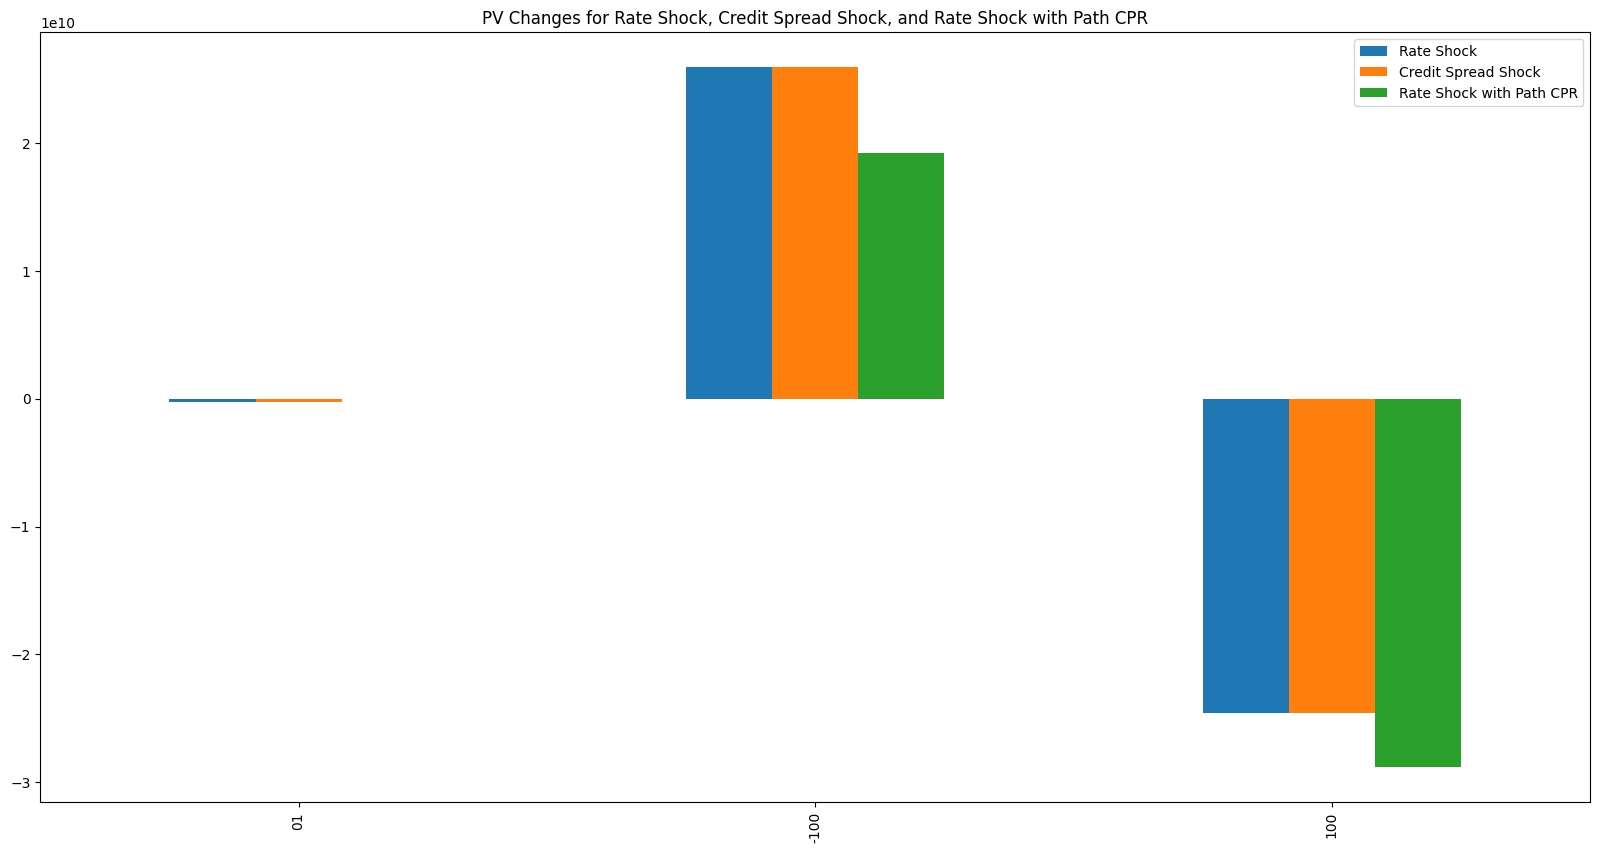

In [43]:
plot_result = pd.DataFrame(
    {
        '01': [PV01, CS_PV01, np.nan],
        '-100': [PV_minus_100, CS_PV_minus_100, change_PV_minus_100],
        '100': [PV_100, CS_PV_100, change_PV_plus_100]
    },
    index = ['Rate Shock', 'Credit Spread Shock', 'Rate Shock with Path CPR']
)

plot_result.T.plot(kind='bar', figsize=(20, 10), title='PV Changes for Rate Shock, Credit Spread Shock, and Rate Shock with Path CPR')

## Explanation

#### Explain why PV changes at -100, +100 are different for #2 vs #4.

The reason why when +100, PV for #4 decrease more than ones in #2 is that, simulated CPRs in modeled paths decreases, which slow down the curtailments, which increases the weighted average loan life. Given increasing interest rate and increasing WAL, the MBS price decreases even more than the case when the CPRs are constant. But it does not necessarily mean that the MBS price will always decrease when the interest rate increases it depends on the CPRs, WALs, and yeild curve shape.

The reason why when -100, PV for #4 (gain) is lower than ones in #2 is that, simulated CPRs in modeled paths increases, the curtailment speeds up, less interest payment is made due to curtailment and principal payment increases. The option embedded in the MBS is more valuable when the interest rate decreases and prepayment happens, which leads to a lower MBS price (since MBS sells the option).  

#### Describe the relationship of PV changes for #3 to #2 and #4

The PV changes for #3 to #2 is same. Given other variables fixed, the shocks on the Credit Spread has the same effect on MBS price comparing to the effect of the shocks on the interest rate. It can be noticed through calculation formula, where it has the same effect on discount factor and they are linearly additive. 

For, PV changes for #4, PV changes are at the same magnitude but for increasing interest rate, it increases the loss in MBS price given the yield curve shape and CPRs. For decreasing interest rate, it decreases the gain in MBS price due to short convexity of the MBS. 




<Axes: title={'center': 'CPR Data'}, xlabel='Pay Date'>

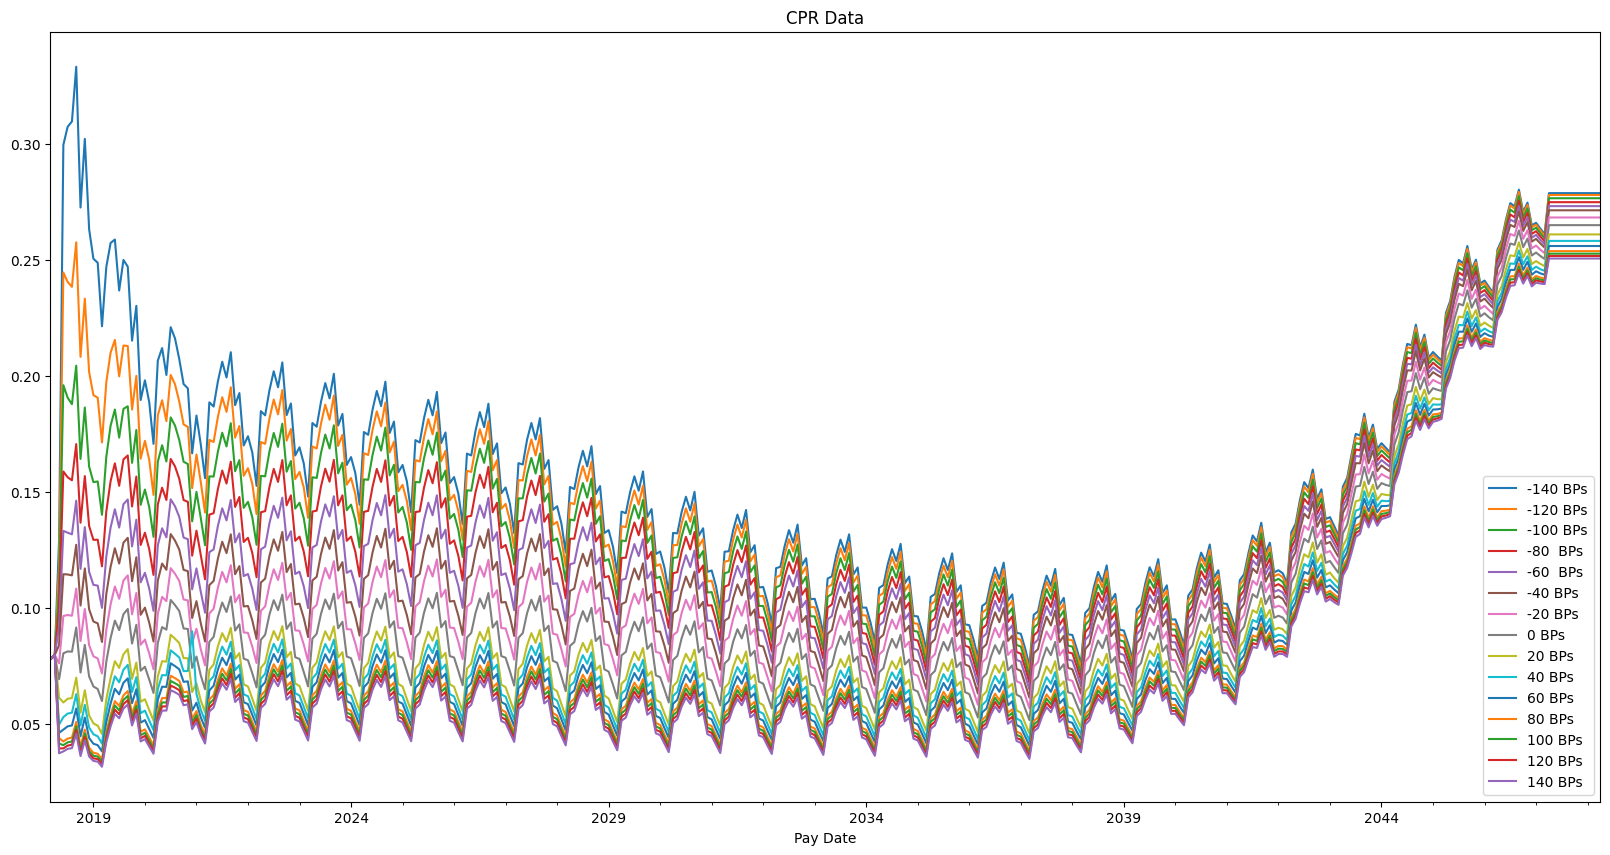

In [44]:
# increase plot size for cpr_data
cpr_data.plot(figsize=(20, 10), title='CPR Data')

# Function Appendix

In [45]:
# def calculate_WAL(all_principal_payments_list, all_balances_list, k, unit = 'year'):
#     """
#     calculate pool weighted average life (WAL)
#     :param all_principal_payments_list: a list of principal payments for each loan from 0 to n (0 is the first principal payment)
#     :param all_balances_list: a list of balances for each loan from 0 to n (principal balance at time 0 is the original loan amount)
#     :param k:
#     :return: WAL pool
#     """
#     numerator = 0
#     denominator = 0
#     for l in range(len(all_principal_payments_list)):
#         all_principal_payments = all_principal_payments_list[l]
#         all_balances = all_balances_list[l]
#         for time in range(k+1, len(all_principal_payments)):
#             numerator += (time - k) * all_principal_payments[time]
#         denominator += all_balances[k]
#     if denominator == 0:
#         return 0
#     if unit == 'year':
#         return round(numerator / denominator / 12, 4)
#     return round(numerator / denominator, 4)